## Data Preparation 

In [1]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
import string
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
twitter_data=pd.read_csv("Twitter_Data.csv")
reddit_data=pd.read_csv("Reddit_Data.csv")

In [3]:
reddit_data=reddit_data[reddit_data["category"].isin([-1,1])]
twitter_data=twitter_data[twitter_data["category"].isin([-1,1])]

In [4]:
reddit_data=reddit_data.rename(columns={"clean_comment":"text"})
twitter_data=twitter_data.rename(columns={"clean_text":"text"})

In [5]:
data=pd.concat([reddit_data,twitter_data])

In [6]:
data["category"].value_counts()

 1.0    88080
-1.0    43787
Name: category, dtype: int64

In [7]:
data=data.sample(frac=1,random_state=100).reset_index(drop=True)

In [8]:
data["category"]=data["category"].replace({-1:0})

In [9]:
data

,text,category
0,kulbhushan not yet hanged pak bcoz modi took t...,1.0
1,these are the founding members the party who b...,0.0
2,dont belive national media surveys\nits all so...,1.0
3,this ended way too soon need more fluff dammit,1.0
4,modi for doing several first and its one them ...,1.0
...,...,...
131862,what nonsense modi talking this the best can g...,1.0
131863,din for bcz china terroristan are their friend...,0.0
131864,have rights defend from american and chinese s...,1.0
131865,atleast antimodi brigade other states agree th...,0.0


In [10]:
data["ug_id"]=np.random.choice(range(1000,10001,250),size=data.shape[0])
data["sm_id"]=None

In [11]:
for n in range(1000,10001,250):
    data.loc[data["ug_id"]==n,"sm_id"] = np.random.choice(range(n+1000,n+2000,100),size=len(data[data["ug_id"]==n]))

In [12]:
data["agent_id"]=np.random.randint(100,150,size=data.shape[0])

In [13]:
import randomtimestamp
import datetime

In [14]:
data["date"]=[randomtimestamp.randomtimestamp(start_year=2020,end_year=2022) for i in range(len(data))]

In [15]:
data

,text,category,ug_id,sm_id,agent_id,date
0,kulbhushan not yet hanged pak bcoz modi took t...,1.0,9250,10650,101,2020-03-18 13:05:17
1,these are the founding members the party who b...,0.0,7500,8700,124,2021-08-13 12:32:26
2,dont belive national media surveys\nits all so...,1.0,1000,2500,129,2021-03-10 07:14:51
3,this ended way too soon need more fluff dammit,1.0,10000,11400,128,2021-04-12 01:59:00
4,modi for doing several first and its one them ...,1.0,6000,7800,124,2021-10-20 14:04:50
...,...,...,...,...,...,...
131862,what nonsense modi talking this the best can g...,1.0,5750,7350,145,2020-06-07 10:43:01
131863,din for bcz china terroristan are their friend...,0.0,4000,5200,102,2020-03-28 23:43:33
131864,have rights defend from american and chinese s...,1.0,1000,2500,142,2021-02-06 20:24:04
131865,atleast antimodi brigade other states agree th...,0.0,9000,10900,112,2021-09-04 16:23:07


## Data Preprocessing

In [16]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

PUNCT_TO_REMOVE = string.punctuation + '\t\n\r-'
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    translate_dict = dict((c, " ") for c in PUNCT_TO_REMOVE)
    translate_map = str.maketrans(translate_dict)
    return text.translate(translate_map)

def remove_space(text):
    words=[word.strip() for word in text.split()]
    return " ".join(words)

def remove_alpha_numeric_text(x):
    pattern=re.compile(r"\d*[a-zA-Z]+\d+[a-zA-Z]*|[a-zA-Z]*\d+[a-zA-Z]+\d*",flags=re.IGNORECASE)
    cleaned_string=re.sub(pattern,'',x)
    return cleaned_string

def remove_stopwords(text):
    return " ".join([word.strip() for word in text.split() if word not in set(stopwords.words("english"))])
    
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [17]:
data=data.dropna()

In [18]:
data

,text,category,ug_id,sm_id,agent_id,date
0,kulbhushan not yet hanged pak bcoz modi took t...,1.0,9250,10650,101,2020-03-18 13:05:17
1,these are the founding members the party who b...,0.0,7500,8700,124,2021-08-13 12:32:26
2,dont belive national media surveys\nits all so...,1.0,1000,2500,129,2021-03-10 07:14:51
3,this ended way too soon need more fluff dammit,1.0,10000,11400,128,2021-04-12 01:59:00
4,modi for doing several first and its one them ...,1.0,6000,7800,124,2021-10-20 14:04:50
...,...,...,...,...,...,...
131862,what nonsense modi talking this the best can g...,1.0,5750,7350,145,2020-06-07 10:43:01
131863,din for bcz china terroristan are their friend...,0.0,4000,5200,102,2020-03-28 23:43:33
131864,have rights defend from american and chinese s...,1.0,1000,2500,142,2021-02-06 20:24:04
131865,atleast antimodi brigade other states agree th...,0.0,9000,10900,112,2021-09-04 16:23:07


In [19]:
data["gmailunit_id"]=np.random.randint(5004001,9182938193,data.shape[0])

/var/folders/gk/_ldt14tj7b3540d0qg9g3tph0000gn/T/ipykernel_760/2536948350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gmailunit_id"]=np.random.randint(5004001,9182938193,data.shape[0])


In [20]:
data=data[["ug_id","sm_id","gmailunit_id","agent_id","date","text","category"]]

In [21]:
data_n=data[data["category"]==0].sample(n=20000,random_state=50)
data_p=data[data["category"]==1].sample(n=20000,random_state=50)
df=pd.concat([data_p,data_n])

In [22]:
data.shape

(131865, 7)

In [24]:
df["text"] =df["text"].str.lower()
df["text"] = df["text"].apply(lambda x : remove_punctuation(x))
df["text"]= df["text"].apply(lambda x : remove_space(x))
df["text"] = df["text"].apply(lambda x: remove_alpha_numeric_text(x))
df["text"]=df["text"].apply(lambda x: remove_stopwords(x))



In [25]:
df["text"]= df["text"].apply(lambda x: lemmatize_words(x))

In [26]:
# Embedding Generation -> Converting Strings/Words into a mathematical representation
import random
seed_value = 99
random.seed(seed_value)
np.random.seed(seed_value)

def tfidf_vectorization(df):
    
    count = TfidfVectorizer()
    count.fit(df["text"])
    features_tfidf = count.transform(df["text"])
    
    return features_tfidf

X = tfidf_vectorization(df)

In [27]:
count = TfidfVectorizer()
count.fit(df["text"])
features_tfidf = count.transform(df["text"])

In [28]:
X.shape

(40000, 45974)

In [29]:
train_X,test_X,train_y,test_y=train_test_split(X,df["category"],test_size=0.25,stratify=df["category"])

In [30]:
lr=LogisticRegression()

In [31]:
lr.fit(train_X,train_y)

LogisticRegression()

In [32]:
pred=lr.predict(test_X)

In [33]:
from sklearn.metrics import accuracy_score,precision_score

In [34]:
accuracy_score(test_y,pred)

0.8558

In [35]:
precision_score(test_y,pred)

0.8665018541409147

In [36]:
df["satisfaction_score"]=lr.predict_proba(X)[:,1]*100

In [37]:
df["satisfaction_score"]=df["satisfaction_score"].round(2)

In [38]:
result=df[["ug_id","sm_id","gmailunit_id","agent_id","date","satisfaction_score"]]

In [39]:
result

,ug_id,sm_id,gmailunit_id,agent_id,date,satisfaction_score
55716,8000,9800,9097318722,131,2022-04-04 20:39:37,66.27
108907,6750,7850,5445691566,133,2020-12-09 11:53:35,21.87
40264,6500,7800,1951212172,142,2022-08-16 17:32:46,74.42
65611,8750,10650,342531107,110,2022-05-05 09:07:43,88.29
21033,4250,5350,5574185202,138,2021-09-29 10:45:18,96.14
...,...,...,...,...,...,...
65799,8250,10050,6544482198,124,2022-12-09 21:29:24,3.51
120618,1750,3150,6744835875,124,2020-03-08 14:03:21,7.76
18853,4750,6550,6994456955,104,2021-02-19 10:48:02,2.18
10058,8750,9950,3043922568,110,2020-10-08 19:52:42,3.97


In [40]:
import pickle

In [41]:
with open("vectorizer.pkl","wb") as f:
    pickle.dump(count,f)

In [42]:
with open("model.pkl","wb") as f:
    pickle.dump(lr,f)

In [197]:
text=input("Write Something to the Agent")
text=text.lower()
text=remove_punctuation(text)
text=remove_space(text)
text=remove_stopwords(text)
vect=count.transform([text]).toarray()
print("The customer satisfaction score is ",np.round(lr.predict_proba(vect)[:,1][0]*100))

Write Something to the AgentAgent was awesome. He just solved my issue right away
The customer satisfaction score is  96.0


In [198]:
text="It was really bad experience, agent took too long to resolve my issue"
text="Satish was awesome. He just solved my issue right away"

## Analytics using Satisfaction Scores

In [53]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sm id vs Average Satisfaction Score')

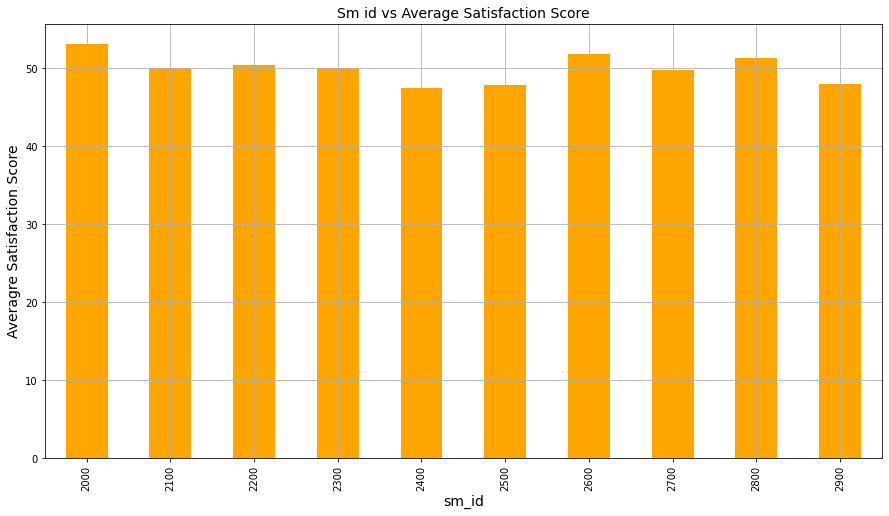

In [115]:
plt.figure(figsize=(15,8))
df[df["ug_id"]==1000].groupby("sm_id")["satisfaction_score"].mean().plot(kind="bar",color='orange')
plt.xlabel("sm_id",fontsize=14)
plt.grid()
plt.ylabel("Average Satisfaction Score",fontsize=14)
plt.title("Sm id vs Average Satisfaction Score",fontsize=14)

Text(0.5, 1.0, 'Sm id vs Minimu Satisfaction Score')

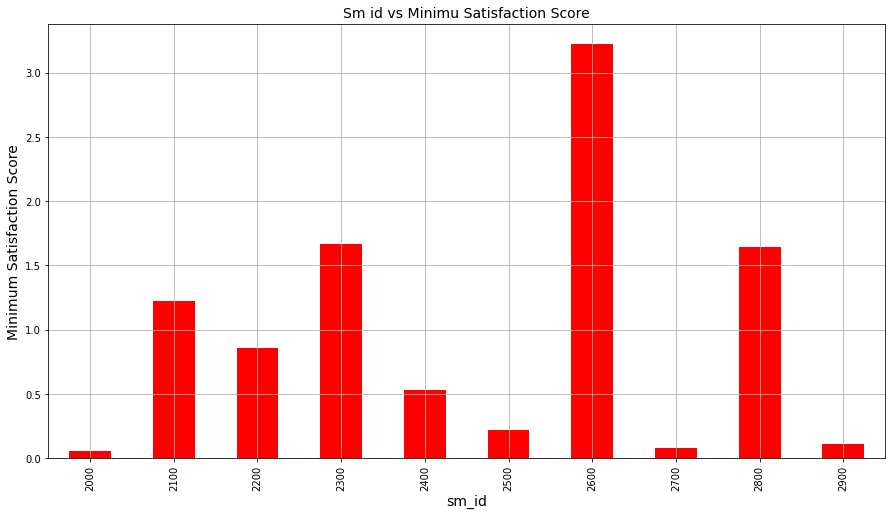

In [122]:
plt.figure(figsize=(15,8))
df[df["ug_id"]==1000].groupby("sm_id")["satisfaction_score"].min().plot(kind="bar",color="red")
plt.xlabel("sm_id",fontsize=14)
plt.grid()
plt.ylabel("Minimum Satisfaction Score",fontsize=14)
plt.title("Sm id vs Minimu Satisfaction Score",fontsize=14)

Text(0.5, 1.0, 'Sm id vs Maximum Satisfaction Score')

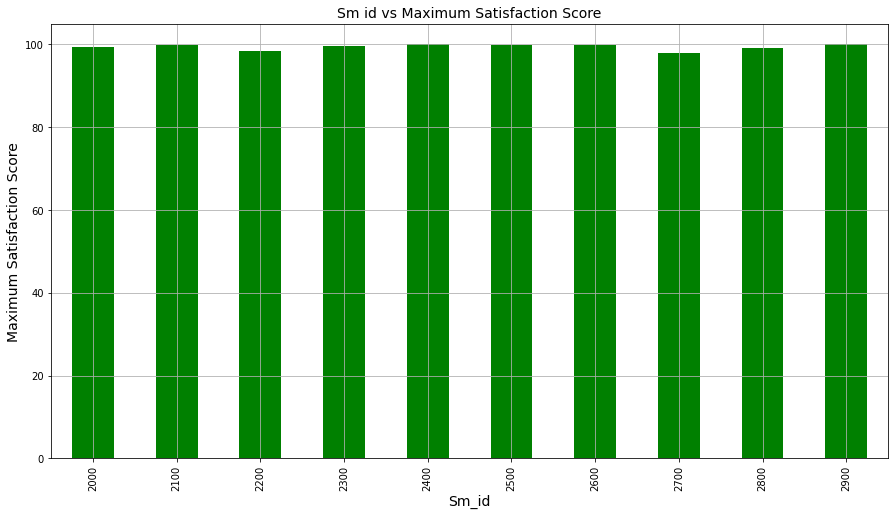

In [110]:
plt.figure(figsize=(15,8))
df[df["ug_id"]==1000].groupby("sm_id")["satisfaction_score"].max().plot(kind="bar",color="green")
plt.xlabel("Sm_id",fontsize=14)
plt.grid()
plt.ylabel("Maximum Satisfaction Score",fontsize=14)
plt.title("Sm id vs Maximum Satisfaction Score",fontsize=14)

Text(0.5, 1.0, 'Agent id vs Average Satisfaction Score')

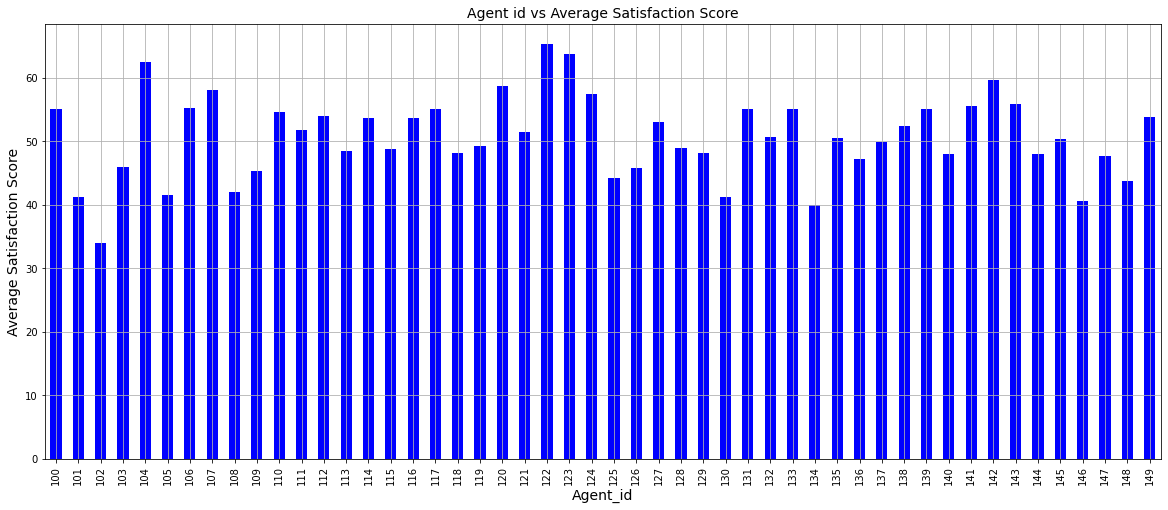

In [109]:
plt.figure(figsize=(20,8))
df[df["ug_id"]==8250].groupby("agent_id")["satisfaction_score"].mean().plot(kind="bar",color="blue")
plt.grid()
plt.xlabel("Agent_id",fontsize=14)
plt.ylabel("Average Satisfaction Score",fontsize=14)
plt.title("Agent id vs Average Satisfaction Score",fontsize=14)

Text(0.5, 1.0, 'Time vs Average Satisfaction Score for sm_id 7800')

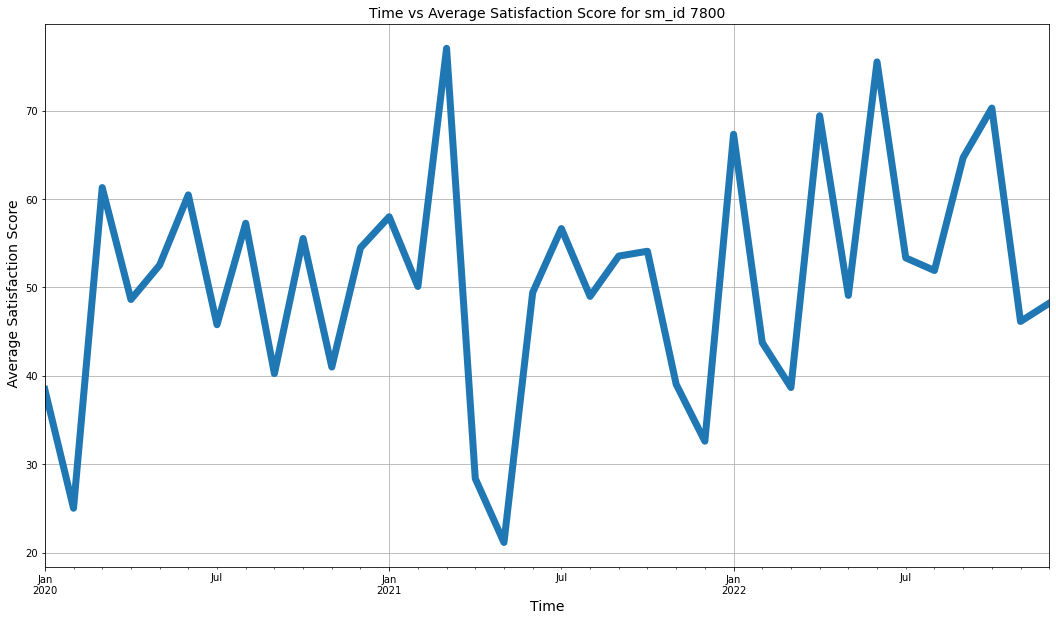

In [106]:
plt.figure(figsize=(18,10))
df[df["sm_id"]==7800].set_index("date")["satisfaction_score"].resample("M").mean().plot(linewidth=7,grid=True)
plt.xlabel("Time",fontsize=14)
plt.ylabel(" Average Satisfaction Score",fontsize=14)
plt.title("Time vs Average Satisfaction Score for sm_id 7800",fontsize=14)

In [126]:
import requests

In [134]:
url="https://8443-27-7-145-99.in.ngrok.io/scores"

In [ ]:
body={
    
}
requests.post()

In [128]:
df["ug_id"].value_counts()

8250     1157
5500     1130
1750     1124
4250     1118
7500     1116
5250     1114
9750     1114
1000     1113
3000     1111
6750     1108
5750     1106
4000     1104
1500     1101
3250     1098
9500     1094
5000     1092
6500     1082
6000     1082
8500     1076
3750     1075
2500     1073
4500     1071
4750     1070
6250     1066
1250     1064
9000     1063
7000     1063
2750     1059
8750     1059
7750     1056
9250     1049
3500     1045
2250     1043
2000     1039
8000     1033
7250     1020
10000    1012
Name: ug_id, dtype: int64

In [182]:
for i,row in df[df["ug_id"].isin([8250,5500,1750])].iterrows():
    if i > 2900:
        body={
          "id": i,
          "company_id": row["ug_id"],
          "gmailunit_id": row["gmailunit_id"],
          "sentiment_score": row["satisfaction_score"],
          "closed_date": str(row["date"])
        }
        res=requests.post(url=url, json=body)
        if res.status_code != 201:
            print(res.text)
            break

{"detail":"Score already exists"}


In [189]:
res=requests.get(url=url)

In [190]:
res.status_code

200

In [191]:
len(res.json())

267

Text(0.5, 1.0, 'Time vs Average Satisfaction Score for sm_id 7800')

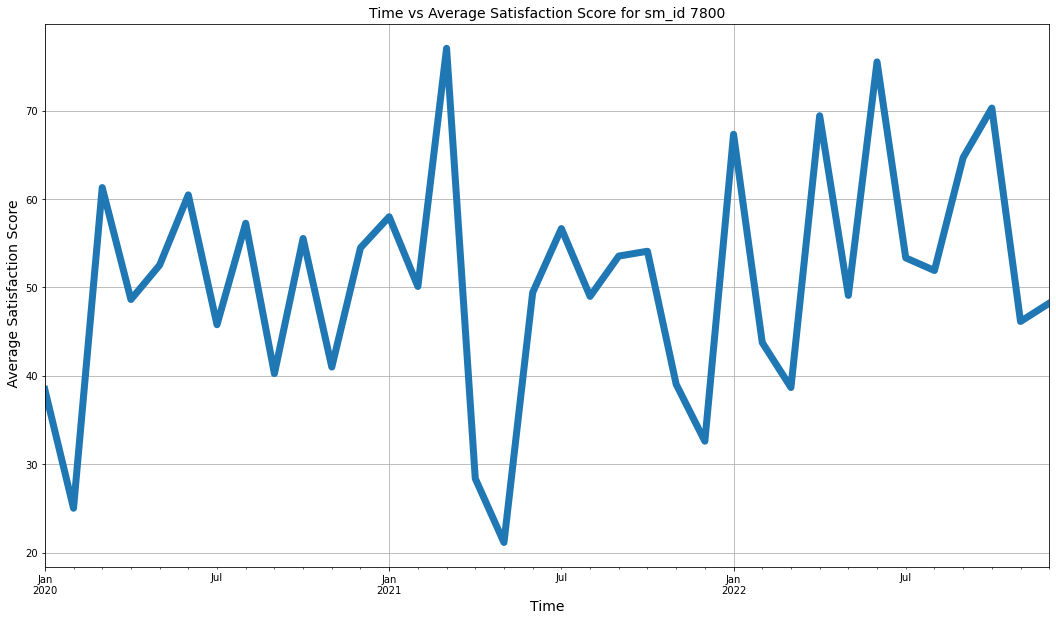

In [193]:
plt.figure(figsize=(18,10))
df[df["sm_id"]==7800].set_index("date")["satisfaction_score"].resample("M").mean().plot(linewidth=7,grid=True)
plt.xlabel("Time",fontsize=14)
plt.ylabel(" Average Satisfaction Score",fontsize=14)
plt.title("Time vs Average Satisfaction Score for sm_id 7800",fontsize=14)